In [1]:
#pip install control

In [2]:
import control

In [3]:
s = control.tf('s')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel('SOPDT.xlsx')

In [6]:
df.describe()

,t,y
count,2501.000000,2501.000000
mean,1250.000000,1.719784
std,722.120835,0.672193
min,0.000000,0.000000
25%,625.000000,1.951081
50%,1250.000000,1.998976
75%,1875.000000,2.007628
max,2500.000000,2.307686


In [7]:
Max_t = df['t'].max()

In [8]:
Delta_t = df._get_value(1, 't') - df._get_value(0, 't')

In [9]:
Count_t = len(df['t'])

## Optimize

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [11]:
def fun(x):
    global df
    
    #Process Gain
    Kp = x[0]
    
    #Natural Period of Oscillation
    Tau = x[1]
    
    #Damping Factor (zeta)
    Zeta = x[2]
    
    #Delay
    Delay = x[3]
  
    A = Tau**2
    B = 2*Zeta*Tau
    C = 1
    sys = Kp/(A*s**2 + B*s + 1)
       
    num, den = control.pade(Delay, n=2, numdeg=0)
    Pade = control.tf(num, den)
    
    SOPDT = control.series(sys, Pade)
      
    # Simulate step response
    t_fun, y_fun = control.step_response(SOPDT, T=Max_t, T_num=Count_t)
    df_fun = pd.DataFrame({'t_fun':t_fun, 'y_fun':y_fun})
    
    mse = mean_squared_error(df_fun['y_fun'], df['y'])
    return mse

In [12]:
ChuteKp= df['y'].max()-df['y'].min()
ChuteTau = (df['t'].max()-df['t'].min())/5
ChuteDelay = ChuteTau/10
ChuteZeta = 1.0

In [13]:
x0 = [ChuteKp, ChuteTau, ChuteZeta, ChuteDelay]

In [14]:
bnds = ((0, None), (0, None), (0, None), (0, None))

In [15]:
res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, tol=1e-6)

In [16]:
Kp_opt = res.x[0]
Tau_opt = res.x[1]
Zeta_opt = res.x[2]
Delay_opt = res.x[3]

A = Tau_opt**2
B = 2*Zeta_opt*Tau_opt
C = 1
sys = Kp_opt/(A*s**2 + B*s + 1)

num, den = control.pade(Delay_opt, n=2, numdeg=0)
Pade = control.tf(num, den)
    
sys_opt = control.series(sys, Pade)

In [17]:
print('Kp=', Kp_opt)
print('Tau=', Tau_opt)
print('Zeta=', Zeta_opt)
print('Delay=', Delay_opt)

Kp= 2.000000000464552
Tau= 149.99999974081757
Zeta= 0.5000000002601392
Delay= 200.00000031303063


## Plots

In [18]:
t_opt, y_opt = control.step_response(sys_opt, T=Max_t, T_num=Count_t)

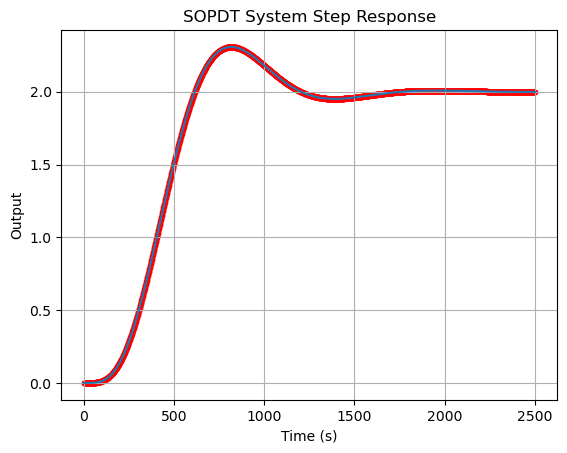

In [20]:
# Plot step response
plt.plot(t_opt,y_opt)
plt.scatter(df['t'], df['y'], marker= ".", color = "red")
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('SOPDT System Step Response')
plt.grid()
plt.show()